In [2]:
# Metodos y funciones para leer cubo fits

from astropy.io import fits # modulo para leer archivos.fits

# Construct the raw content URL for the FITS file on GitHub
base_url = 'https://raw.githubusercontent.com/amaliamartinez-netizen/cubo-de-datos/main'
cubo = fits.open(base_url + '/Cubo_de_datos.fits') #abrimos el cubo de datos
data = cubo[0].data # extraemos matriz de datos
header = cubo[0].header #extraemos el header del archivo fits

In [3]:
import numpy as np #este modulo es para trabajar con arreglos en general (vectores, matrices)
import math

# definimos función para extraer ejes del cubo con las unidades correspondientes

def cube_axis(hdr):
    axis = hdr['NAXIS']
    axis_dict = {}
    for i in range(axis):
        min_val_i = float(hdr['CRVAL' + str(i + 1)])
        delt_i = float(hdr['CDELT' + str(i + 1)])
        Naxis_i = int(hdr['NAXIS' + str(i + 1)])
        axis_i = np.linspace(min_val_i, min_val_i + (Naxis_i - 1)*delt_i, Naxis_i)
        axis_dict[hdr['CTYPE' + str(i + 1)]] = axis_i
    return axis_dict

axis_dict = cube_axis(header)

# Extraemos los vectores de los ejes

velocidad = axis_dict['VELO-LSR']
longitud = axis_dict['GLON-FLT']
latitud = axis_dict['GLAT-FLT']

header

 [astropy.io.fits.verify]



SIMPLE  =                    T  / Standard FITS format                          
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3  / Number of axes                                
NAXIS1  =                  306  / Number pixels on axis 1                       
NAXIS2  =                  385  / Number pixels on axis 2                       
NAXIS3  =                   33  / Number pixels on axis 3                       
CTYPE1  = 'VELO-LSR'            / axis 1 coord type                             
CRVAL1  =        -2.307985E+02 / coord value at CRPIX1                          
CDELT1  =         1.300400E+00 / pixel spacing for axis 1                       
CRPIX1  =             1.000000  / ref pixel for axis 1                          
CTYPE2  = 'GLON-FLT'            / axis 2 coord type                             
CRVAL2  =         3.000000E+02 / coord value at CRPIX2                          
CDELT2  =         1.250000E-

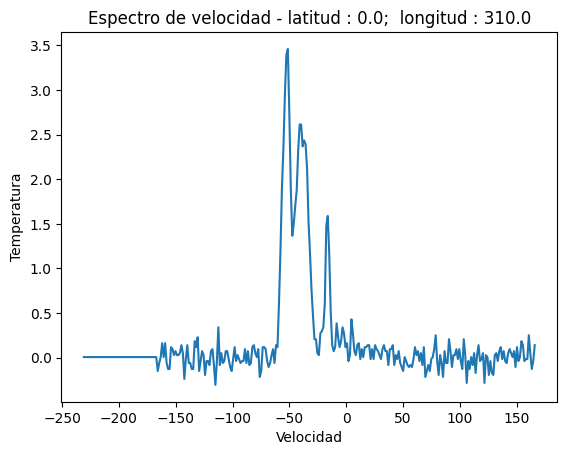

In [4]:
import matplotlib.pyplot as plt

# eje 1: latitud (data[0]) (b)
# eje 2: longitud(data[0][0]) (l)
# eje 3: velocidad (data[0][0][0])

# Funcion para encontrar un indice en un arreglo del valor mas cercano a un valor dado. Solo funciona si el array esta ordenado
def nearest_ind(arr, val):
    ind = 0
    for i in range(len(arr)):
        if arr[i] <= val:
            ind = i
        else:
            return ind
    return ind

# Espectro de velocidad

lat_2 = 0.
lat_2_i = nearest_ind(latitud, lat_2)
lat_2 = latitud[lat_2_i]

lon_2 = 310.
lon_2_i = nearest_ind(longitud, lon_2)
lon_2 = longitud[lon_2_i]

info = 'latitud : ' + str(np.round(lat_2, 4)) + ';  longitud : ' + str(np.round(lon_2, 4))

T_spect = data[lat_2_i][lon_2_i][:]

#ahora graficamos el espectro
plt.plot(velocidad, T_spect)
plt.xlabel('Velocidad')
plt.ylabel('Temperatura')
plt.title('Espectro de velocidad - ' + info)
plt.show()

# Filtrado de espectro

Al ver un espectro, podemos notar que no todas las mediciones de temperatura corresponden a observaciones. Nos interesa establecer un criterio para poder extraer los datos asociados a observaciones, y separarlas del ruido. Para esto usamos como referencia para la temperatura $\sigma$, que corresponde a la desviacion estandar del "ruido".

\begin{equation}
    \sigma_T = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (T_i - T_{promedio})^2}
\end{equation}

El criterio establecido es el de considerar como observaciones a temperaturas $T \geq 5*\sigma_T$.

In [5]:
from scipy import stats
from astropy.stats import sigma_clip

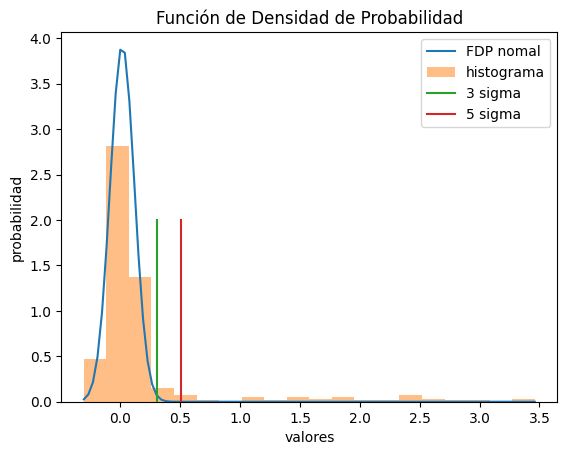

In [6]:
# Primero revisamos la distribucion de probabilidad de temperaturas

r = sigma_clip(T_spect, sigma_lower=3, sigma_upper=3) # extraemos un subconjunto del espectro que contiene ruido principalmente
mean_spect = np.mean(r) # promedio
std_spect = np.sqrt(np.mean(r**2)) # desviacion estandar

x_t = np.linspace(min(T_spect), max(T_spect), 100) # vector con rango de T_spect

FDP_normal = stats.norm(mean_spect, std_spect).pdf(x_t) # distribucion de probabilidades normal

plt.plot(x_t, FDP_normal, label='FDP nomal') # graficamos la distribucion de probabilidades
plt.hist(T_spect, density=True, alpha=0.5, bins = 20, label = 'histograma') # graficamos un histograma
plt.plot(np.array([3*std_spect, 3*std_spect]), np.array([0, 2]), label = '3 sigma')
plt.plot(np.array([5*std_spect, 5*std_spect]), np.array([0, 2]), label = '5 sigma')

plt.title('Función de Densidad de Probabilidad')
plt.ylabel('probabilidad')
plt.xlabel('valores')
plt.legend(loc = 'upper right')
plt.show()

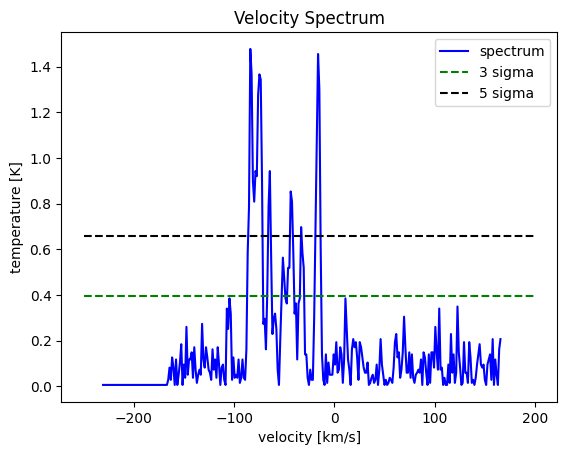

In [7]:
T_spc = data[14,200,:] # espectro de velocidad (temperatura)

r = sigma_clip(T_spc, sigma_lower=3, sigma_upper=3) # extraemos un subconjunto del espectro que contiene ruido principalmente
sigma_T = np.sqrt(np.mean(r**2)) # calculamos RMS del subconjunto anterior

plt.plot(velocidad, abs(T_spc), color='b', label='spectrum')
plt.plot([-250,200],[3*sigma_T,3*sigma_T], 'g--', label='3 sigma')
plt.plot([-250,200],[5*sigma_T,5*sigma_T], 'k--', label='5 sigma')
plt.xlabel('velocity [km/s]')
plt.ylabel('temperature [K]')
plt.legend()
plt.title('Velocity Spectrum')
plt.show()

# Curva de rotación

### Velocidad tangencial

Nuestro primer objetivo es encontrar la velocidad tangencial asociada a una circunferencia de radio $R = R_\odot \sin(l)$. Para esto, definimos la velocidad tangencial para un par de coordenadas, $V_{max}(l, b)$ como la velocidad del espectro de mayor valor absoluto, para temperaturas de medicion que cumplan la condición $T \geq 5\sigma$. Luego, fijamos $l$ y vamos recorriendo $b$, almacenando las velocidades $V_{max}(l, b)$. La velocidad tangencial que buscamos es el máximo de las velocidades almacenadas anteriormente, y está asociada a la coordenada l.

\begin{equation}
    V_{tan} = V_{max}(l, b^*) \\
    b^* = \arg \max_{b} (V_{max}(l, b))
\end{equation}

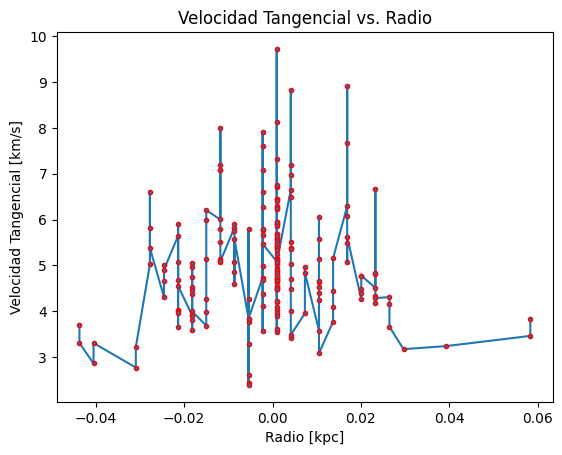

In [27]:

v_max=np.zeros(33)
v_tan_vec= np.zeros(200)
R= np.zeros(200)
l=data[0][0]
# tomamos R sun como 8,2 kpc
for j in range(200):
  for i in range(33):
      T_spc = data[i][j][:]
      r = sigma_clip(T_spc, sigma_lower=3, sigma_upper=3)
      sigma_T = np.sqrt(np.mean(r**2))
      mask= T_spc >= 5*sigma_T
      if T_spc[mask].size == 0:
          v_max[i]=0
      else:
        v_max[i]=max(np.absolute(T_spc[mask]))
      R[j]= 8.2*np.sin(np.radians(l[j]))
  b_max=np.argmax(v_max)
  v_tan_vec[j]=v_max[b_max]
R_ord=sorted(R)
plt.plot(R_ord, v_tan_vec, marker=".", mec="r")
plt.title("Velocidad Tangencial vs. Radio")
plt.xlabel("Radio [kpc]")
plt.ylabel("Velocidad Tangencial [km/s]")
plt.show()

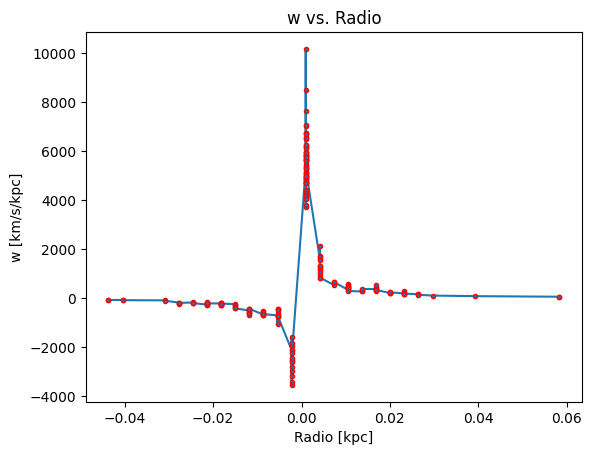

In [28]:
w=v_tan_vec/R_ord
plt.plot(R_ord, w, marker=".", mec="r")
plt.title("w vs. Radio")
plt.xlabel("Radio [kpc]")
plt.ylabel("w [km/s/kpc]")
plt.show()

# Corrugación del plano

Tenemos que dado un ángulo $l$,

\begin{equation}
    R = R_\odot \sin{l} \\
    D = R_\odot \cos{l} \\
    Z = D \tan{b} \sim D b = R_\odot b \cos{l}
\end{equation}

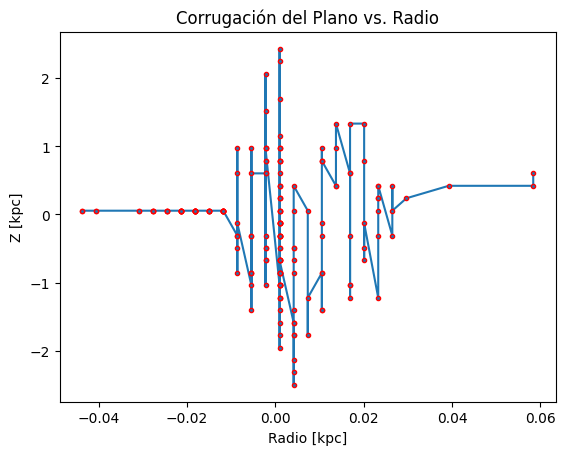

In [30]:
R= np.zeros(200)
Z= np.zeros(200)
b= data[0]
l= data[0][0]
for i in range(200):
  for j in range(33):
    R[i]= 8.2*np.sin(np.radians(l[i]))
    Z[i]= 8.2*np.cos(np.radians(l[i]))*b[j][i]
R_ord=sorted(R)
plt.plot(R_ord, Z, marker=".", mec="r")
plt.title("Corrugación del Plano vs. Radio")
plt.xlabel("Radio [kpc]")
plt.ylabel("Z [kpc]")
plt.show()

# Modelos de curva de rotación

Ajustamos 5 modelos de la curva de rotación. Lo que hacemos es modelar la masa de la galaxia, y calculamos la velocidad utilizando conservación de energía.